In [1]:
from numpy.random import seed
from tensorflow.random import set_seed
seed(1)
set_seed(2)

import pandas as pd
import numpy as np

import glob

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

from tqdm.notebook import tqdm


import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

path_data="D:\\BTP\\Data\\site_data_processed"

csv_files=glob.glob(f"{path_data}/*.csv")

In [2]:
def linear_int(data):
    valid_indices = np.arange(len(data))
    valid_data = ~np.isnan(data)
    interpolated_data = np.interp(valid_indices, valid_indices[valid_data], data[valid_data])
    return list(interpolated_data)

In [3]:
df_station_info=pd.read_excel(f"D:\\BTP\\Data/station_info.xlsx")
df_station_info.sort_values('avg_nan').head(10)

,siteid,site_name,mean,median,std,2019_score,2020_score,2021_score,2022_score,avg_nan
49,site_1428,"Okhla Phase-2, Delhi - DPCC",100.250825,63.00,99.421634,0.033790,0.018414,0.035360,0.014441,0.025501
46,site_1425,"Major Dhyan Chand National Stadium, Delhi - DPCC",94.823641,64.00,86.033359,0.016924,0.028518,0.023116,0.037357,0.026479
50,site_1429,"Nehru Nagar, Delhi - DPCC",117.876716,72.00,122.783660,0.013584,0.030254,0.033276,0.030080,0.026799
79,site_1562,"Sri Aurobindo Marg, Delhi - DPCC",85.997819,57.00,81.322137,0.015925,0.030482,0.036672,0.032049,0.028782
43,site_1422,"Dwarka-Sector 8, Delhi - DPCC",104.286467,68.00,99.081295,0.013071,0.044342,0.031393,0.038841,0.031912
0,site_103,"CRRI Mathura Road, Delhi - IMD",99.736719,68.56,94.940512,0.041495,0.016137,0.053339,0.032306,0.035819
52,site_1431,"Patparganj, Delhi - DPCC",105.770728,70.00,100.212410,0.023002,0.033498,0.050713,0.046404,0.038405
77,site_1560,"Bawana, Delhi - DPCC",121.563329,83.00,109.257739,0.020519,0.062329,0.048773,0.022146,0.038442
57,site_1437,"Model Town, Patiala - PPCB",44.739282,37.68,32.366210,0.044521,0.036003,0.042266,0.042409,0.041300
47,site_1426,"Narela, Delhi - DPCC",111.499519,75.00,102.080149,0.024600,0.066029,0.038756,0.039669,0.042264


In [4]:
site_id=1428

df=pd.read_csv(f'{path_data}/site_{site_id}.csv')
station_name=df['siteName'].unique()[0]
print('Station Name:',station_name)
df['from date']=pd.to_datetime(df['from date'])
df=df[['from date','PM2.5','PM10','SO2',"NO2",'Ozone','NH3']]
df=df[df['from date']>='01-01-2019']
df=df[df['from date']<'31-12-2022']
df = df.resample('h', on='from date').mean().reset_index()


pollutants=['PM2.5','PM10','SO2',"NO2",'Ozone','NH3']

for pollutant in pollutants:
    df[pollutant]=linear_int(df[pollutant])


df

Station Name: Okhla Phase-2, Delhi - DPCC


,from date,PM2.5,PM10,SO2,NO2,Ozone,NH3
0,2019-01-01 00:00:00,504.25,746.00,14.833333,71.250000,10.966667,97.100000
1,2019-01-01 01:00:00,504.75,707.75,11.300000,67.866667,8.250000,89.466667
2,2019-01-01 02:00:00,482.25,655.50,10.400000,60.750000,7.500000,83.650000
3,2019-01-01 03:00:00,426.25,574.50,10.000000,58.900000,6.400000,84.150000
4,2019-01-01 04:00:00,365.50,488.00,9.950000,58.575000,6.050000,85.775000
...,...,...,...,...,...,...,...
35035,2022-12-30 19:00:00,315.25,559.50,12.300000,92.675000,3.450000,94.100000
35036,2022-12-30 20:00:00,377.75,632.25,12.475000,83.125000,2.750000,95.725000
35037,2022-12-30 21:00:00,478.25,698.50,12.950000,71.250000,3.575000,96.825000
35038,2022-12-30 22:00:00,453.50,630.75,8.575000,66.700000,2.825000,86.725000


In [5]:
window=25

def create_ts_data(data,timesteps=window):

    output=[]
    for i in range(len(data)-window+1):
        output.append(data[i:i+window])
    return np.expand_dims(output,axis=2)

In [6]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
#mms=MinMaxScaler()
mms=StandardScaler()
mms.fit(df[['PM2.5']][10000:20000])
data_s=mms.transform(df[['PM2.5']][10000:20000]).reshape(-1)
data_ts=create_ts_data(data_s)
print('Shape :',data_ts.shape)

Shape : (9976, 25, 1)


## Build a model
We will build a convolutional reconstruction autoencoder model. The model will take input of shape (batch_size, sequence_length, num_features) and return output of the same shape. In this case, sequence_length is 288 and num_features is 1.

In [7]:
model = keras.Sequential() 
model.add(keras.layers.LSTM(units=32,input_shape=(data_ts.shape[1], data_ts.shape[2])))
model.add(keras.layers.Dropout(rate=0.1)) 
model.add(keras.layers.RepeatVector(n=data_ts.shape[1])) 
model.add(keras.layers.LSTM(units=32, return_sequences=True)) 
model.add(keras.layers.Dropout(rate=0.1))
model.add(keras.layers.TimeDistributed( keras.layers.Dense(units=data_ts.shape[2])))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 25, 32)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 25, 32)            8320      
                                                                 
 dropout_1 (Dropout)         (None, 25, 32)            0         
                                                                 
 time_distributed (TimeDistr  (None, 25, 1)            33        
 ibuted)                                                

Epoch 1/250
18/18 [==============================] - 38s 421ms/step - loss: 0.5521 - val_loss: 0.3760
Epoch 2/250
18/18 [==============================] - 0s 18ms/step - loss: 0.4039 - val_loss: 0.2981
Epoch 3/250
18/18 [==============================] - 0s 17ms/step - loss: 0.3942 - val_loss: 0.2879
Epoch 4/250
18/18 [==============================] - 3s 152ms/step - loss: 0.3732 - val_loss: 0.2809
Epoch 5/250
18/18 [==============================] - 0s 24ms/step - loss: 0.3429 - val_loss: 0.2768
Epoch 6/250
18/18 [==============================] - 0s 22ms/step - loss: 0.3382 - val_loss: 0.2737
Epoch 7/250
18/18 [==============================] - 3s 198ms/step - loss: 0.3338 - val_loss: 0.2803
Epoch 8/250
18/18 [==============================] - 0s 19ms/step - loss: 0.3304 - val_loss: 0.2680
Epoch 9/250
18/18 [==============================] - 0s 20ms/step - loss: 0.3249 - val_loss: 0.2771
Epoch 10/250
18/18 [==============================] - 3s 167ms/step - loss: 0.3295 - val_loss: 0

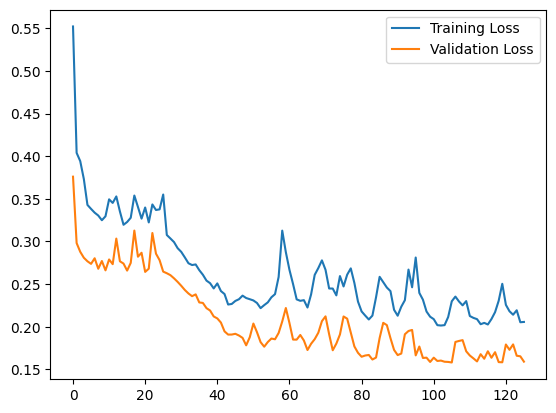

In [8]:
model.compile(loss='mae', optimizer='adam')

history = model.fit( data_ts, data_ts, epochs=250, batch_size=512, 
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, mode="min", restore_best_weights=True,verbose=1)], 
                    shuffle=False)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

312/312 [==============================] - 9s 15ms/step
Reconstruction error threshold:  0.7400076881620286


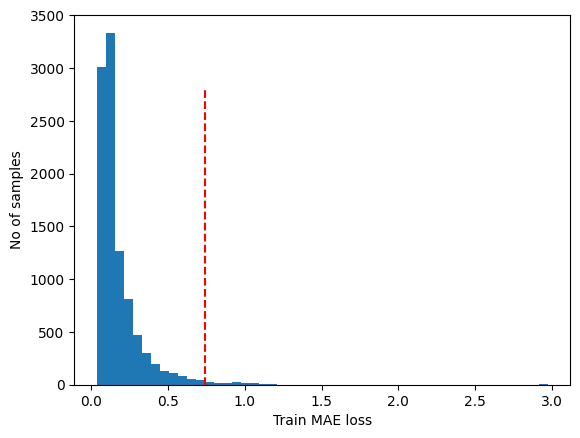

In [9]:
data_ts_pred = model.predict(data_ts)
train_mae_loss=np.mean(np.abs(data_ts_pred - data_ts), axis=1)


threshold = np.mean(train_mae_loss)+3*np.std(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

plt.hist(train_mae_loss, bins=50)
plt.plot([threshold,threshold],[0,2800],'r--')
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

## Validate Model
Use all data points and look at mae b/w model output and actual values

In [10]:
data_all=df[['PM2.5']]
data_all_s=mms.transform(data_all).reshape(-1)
data_ts_org=create_ts_data(data_all['PM2.5'].values)
data_ts_all=create_ts_data(data_all_s)

In [11]:
data_ts_all_pred = model.predict(data_ts_all)
train_mae_loss_all=np.mean(np.abs(data_ts_all_pred - data_ts_all), axis=1)

1095/1095 [==============================] - 22s 20ms/step


In [21]:
threshold=0.75
is_anomaly=tf.math.less(threshold,train_mae_loss_all)
arr=[0 for _ in range(window//2)]
for i in is_anomaly:
    if i.numpy()[0]==True:
        arr.append(1)
    else:
        arr.append(0)
for _ in range(window//2):
    arr.append(0)

In [22]:
df_data=pd.DataFrame({'data':data_all['PM2.5'].values,'is_anomaly':arr})
df_data['from_date']=df['from date'].values
df_data['is_anomaly'].value_counts()

is_anomaly
0    34509
1      531
Name: count, dtype: int64

In [23]:
dummy=[0 for i in range(window//2)]
hover_arr=dummy+list(train_mae_loss_all.reshape(-1))+dummy
df_data['mse']=hover_arr

In [24]:
import plotly.graph_objects as go

trace1 = go.Scatter(x=df_data['from_date'], y=df_data['data'], mode='lines+markers', name='Data', line=dict(color='green'),hovertext=hover_arr)
trace2 = go.Scatter(x=df_data[df_data['is_anomaly']==1]['from_date'], y=df_data[df_data['is_anomaly']==1]['data'],
                   mode='markers', name=f"Anomalies", marker=dict(color='red', size=6),hovertext=df_data[df_data['is_anomaly']==1]['mse'].values)

fig = go.Figure(data=[trace1,trace2])
fig.show()

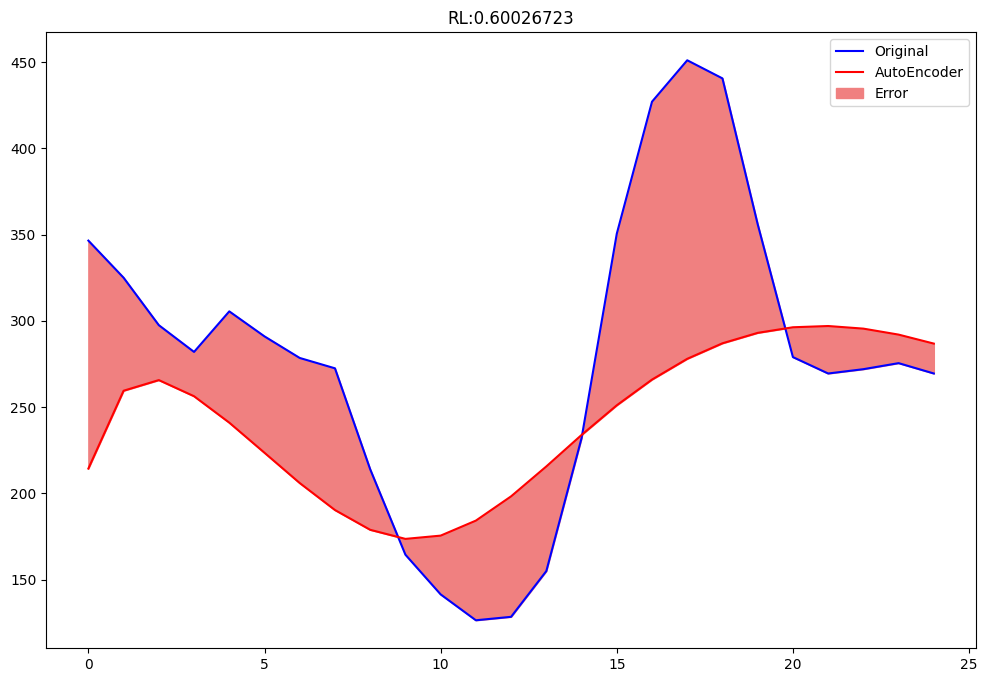

In [25]:
def plot_model(data_original,data,n):
    plt.figure(figsize=(12,8))
    plt.plot(data_original[n].reshape(-1), 'b')
    dec_img=mms.inverse_transform(model.predict(np.expand_dims(data[n], axis=0)).reshape(-1,1)).reshape(-1)
    plt.plot(dec_img, 'r')
    plt.fill_between(np.arange(data.shape[1]), data_original[n].reshape(-1), dec_img, color = 'lightcoral')
    plt.title('RL:'+str(losses.mae(data[n].reshape(-1),model.predict(np.expand_dims(data[n], axis=0)).reshape(-1)).numpy()))
    plt.legend(['Original','AutoEncoder','Error'])
    plt.show()
plot_model(data_ts_org,data_ts_all,100)

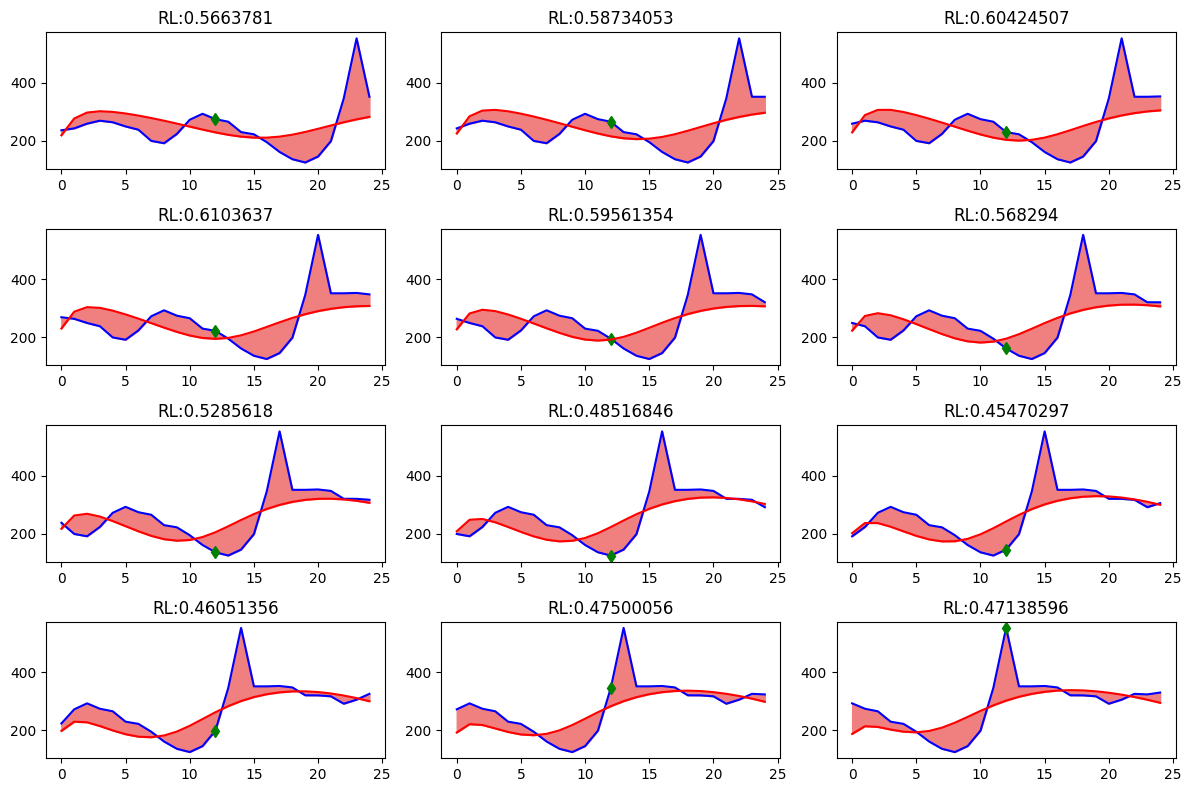

In [26]:
tf.keras.utils.disable_interactive_logging()
plt.figure(figsize=(12,8))
k=1
for i in range(25390,25390+12):
    plt.subplot(4,3,k)
    plt.plot(data_ts_org[i], 'b')
    loss=losses.mae(data_ts_all[i].reshape(-1),model.predict(np.expand_dims(data_ts_all[i], axis=0)).reshape(-1)).numpy()
    if loss>threshold:
        plt.plot([12],[data_ts_org[i][12]], 'kd', label='Outlier')
    else:
        plt.plot([12],[data_ts_org[i][12]], 'gd', label='Not Outlier')

    dec_img = mms.inverse_transform(model.predict(np.expand_dims(data_ts_all[i], axis=0)).reshape(-1,1)).reshape(-1)
    plt.plot(dec_img, 'r')
    plt.fill_between(np.arange(data_ts.shape[1]), data_ts_org.reshape(-1,window)[i], dec_img, color = 'lightcoral')
    plt.title('RL:'+str(loss))
    k+=1
plt.tight_layout(pad=1)
plt.show()

In [27]:
df_data[df_data['is_anomaly']==1].sample(5)

,data,is_anomaly,from_date,mse
24945,446.25,1,2021-11-05 09:00:00,1.461800
8772,167.00,1,2020-01-01 12:00:00,1.870863
33433,775.00,1,2022-10-25 01:00:00,1.388925
8763,583.50,1,2020-01-01 03:00:00,1.900348
26084,452.00,1,2021-12-22 20:00:00,0.775065


In [29]:
df_data.columns=['data','is_anomaly_lstm','from_date','mse_lstm']
df_data.to_csv('lstm_out.csv',index=False)